In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import itertools
import glob
import os
import uuid
import gc
import copy

In [2]:
import sys
sys.path.append('code/BalancingControl')

import tmaze_utils as tu
import inference_utils as iu
import inference as inf

import action_selection as asl
import agent as agt
import perception as prc
import environment as env
import world as wld
import action_selection as asl
import misc

results_dir = os.path.abspath('results')
simulation_folder = os.path.join(results_dir, "simulations")
recovery_folder = os.path.join(results_dir, "recovery")
print(simulation_folder)

Running on device cpu
torch threads 1
/home/sarah/src/BayesianSpatialNav/results/simulations


In [3]:
# load info from preprocessed data, only mask is needed however

group_name = "control"

base_dir = "processed_data"
fname_data = os.path.join(base_dir, f"TMaze_{group_name}_structured_data.json")
structured_animal_data = misc.load_file(fname_data, fname_data)

n_subjects = structured_animal_data["valid"].shape[-1]

print(n_subjects)

8


In [4]:
pars = {}
# three states
ns = 3
# three rewards
nr = 3
# two actions
na = 2
# two contexts (corresponding to training and test)
nc = 2
# each session has two time steps: before and after the choice
T = 2

generative_model_states = np.zeros((ns, ns, na))
# state 0 is middle starting point
prior_states = np.array([1., 0., 0.])
# state 1 is right arm
# state 2 is left arm
# action 0 goes to right arm (state 1)
# action 1 goes to left arm (state 2)
# from the arms actions dont matter but for completeness they lead back to the middle
generative_model_states[...,0] = [[0., 1., 1.],
                                  [1., 0., 0.],
                                  [0., 0., 0.]]
generative_model_states[...,1] = [[0., 1., 1.],
                                  [0., 0., 0.],
                                  [1., 0., 0.]]

# reward 0 is bad outcome
# reward 1 is nothing (middle starting point)
# reward 2 is good outcome
prior_rewards = np.array([0.01, 0.14, 0.85])

# environment rules
# left arm gives reward during training, right arm gives nothing, and switches for the test
# we set 75 trials as the maximum possible (however training stops after criterion is reached)
training_trials = 75
test_trials = 5
total_trials = 2*(training_trials+test_trials)
# set outcome rules
# note that training is repeated twice, so is testing
generative_process_rewards = np.zeros((total_trials,nr,ns))
# state 0 gives non-reward
# state 1 gives bad outcome during training
# state 2 gives reward during training
generative_process_rewards[:training_trials] = np.array([[0., 1., 0.],
                                                         [1., 0., 0.],
                                                         [0., 0., 1.]])

generative_process_rewards[training_trials+test_trials:2*training_trials+test_trials] = np.array([[0., 1., 0.],
                                                         [1., 0., 0.],
                                                         [0., 0., 1.]])

# state 1 gives reward turing test
# state 2 gives bad outcome during test
generative_process_rewards[training_trials:training_trials+test_trials] = np.array([[0., 0., 1.],
                                                         [1., 0., 0.],
                                                         [0., 1., 0.]])

generative_process_rewards[2*training_trials+test_trials:] = np.array([[0., 0., 1.],
                                                         [1., 0., 0.],
                                                         [0., 1., 0.]])

# lastly, set up dummy observation model: states are fully observable
generative_model_observations = np.eye(ns)

In [5]:
pars["nm"] = ns
pars["nh"] = ns
pars["nr"] = nr
pars["na"] = na
pars["nc"] = nc
pars["trials"] = total_trials
pars["T"] = T

pars["generative_model_states"] = generative_model_states
pars["generative_model_observations"] = generative_model_observations

In [6]:
env_pars = copy.deepcopy(pars)
env_pars["generative_process_rewards"] = generative_process_rewards

In [7]:
# agent inits

# init reward counts
reward_counts = np.ones((nr,ns,nc))#

# context transition matrix with self transition context stability bias.
self_transition_bias = 0.45
context_transition_matrix = np.array([[0.5+self_transition_bias, 0.5-self_transition_bias],
                                      [0.5-self_transition_bias, 0.5+self_transition_bias]])

# start in one context
prior_context = np.array([1., 0.])

# there are only two policies, one with action 0 and one with action 1
policies = np.array([[0], [1]])
npi = 2

In [8]:
pars["npi"] = npi
pars["transition_matrix_context"] = context_transition_matrix

pars["prior_states"] = prior_states
pars["prior_rewards"] = prior_rewards
pars["prior_context"] = prior_context

pars["all_policies"] = policies

pars["dirichlet_rew_params"] = reward_counts

In [9]:
# extra agent parameters

pars["infer_context"] = True
pars["store_internal_variables"] = True

# and things we are not doing:
pars["learn_context_obs"] = False
pars["hidden_state_mapping"] = False
pars["infer_alpha_0"] = False
pars["infer_decision_temp"] = False
pars["infer_policy_rate"] = False
pars["infer_reward_rate"] = False
pars["dirichlet_context_obs_params"] = np.ones((nc, nc))

In [10]:
# set parameters and their names

learn_rewards = True
learn_habit = False
use_h = False
learn_cached = False
use_forgetting_rates = False

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 1
    param_names += ["dec temp"]
    param_ranges += [[0,8]]
    agnt_str += "_planning"
    if use_forgetting_rates:
        n_pars += 1
        param_names += ["reward rate"]
        param_ranges += [[0,1]]
        agnt_str += "_rewl"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 1
    agnt_str += "_repetition"
    param_names += ["habitual tendency"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8]]
    if use_forgetting_rates:
        n_pars += 1
        agnt_str += "_repl"
        param_names += ["policy rate"]
        param_ranges += [[0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 1
    param_names += ["cached weight"]
    param_ranges += [[0,8]]
    agnt_str += "_cached"
    if use_forgetting_rates:
        n_pars += 1
        param_names += ["cached rate"]
        param_ranges += [[0,8]]
        agnt_str += "_cachl"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 3

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str
print(agent_type)
fname_base = agent_type+"_simulation_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(simulation_folder,fname_base[:-1])
if fname_base[:-1] not in os.listdir(simulation_folder):
    os.mkdir(base_dir)

BCC_1pars_planning
BCC_1pars_planning_simulation_


In [11]:
pars["learn_habit"] = learn_habit
pars["learn_rew"] = learn_rewards
pars["learn_cached"] = learn_cached
pars["use_h"] = use_h


In [12]:
# number of agent subjects to simulate and recover:

run_simulations = True           # Set to false if simulations were already run previously. In that case the _data_long_format.xlsx file will be used to create plots.

In [13]:
remove_old = True           # Set to false, unless your want to clean up all files. Danger!

In [14]:
# if it does exist, empty previous results, if we want that (remove_old==True), but only if we are making new simulations (run_simulations==True)
if remove_old and run_simulations:
        
    svgs = glob.glob(os.path.join(base_dir,"*.svg"))
    for file in svgs:
        os.remove(file)
        
    csvs = glob.glob(os.path.join(base_dir,"*.csv"))
    for file in csvs:
        os.remove(file)
        
    saves = glob.glob(os.path.join(base_dir,"*.save"))
    for file in saves:
        os.remove(file)
        
    agents = glob.glob(os.path.join(base_dir,f"{agent_type}_simulation_*"))
    for file in agents:
        os.remove(file)

### Run simulations

In [15]:
##############################################
####### INPUT    SIMULATION     VALUES #######
##############################################

# probability of NaN answer
p_invalid = 0.01

#parameters that we are indeed varying:
if learn_rewards:
    true_vals_dec_temp = np.random.rand(n_subjects,1)
else:
    true_vals_dec_temp = np.zeros((n_subjects,1))
if learn_rewards and use_forgetting_rates:
    true_vals_r_lambda = np.random.rand(n_subjects,1)
else:
    true_vals_r_lambda = np.zeros((n_subjects,1))

if learn_habit:
    true_vals_hab_tend = np.random.rand(n_subjects,1)
else:
    true_vals_hab_tend = np.zeros((n_subjects,1))
if learn_habit and use_forgetting_rates:
    true_vals_pol_lambda = np.random.rand(n_subjects,1)
else:
    true_vals_pol_lambda = np.zeros((n_subjects,1))

if learn_cached:
    true_vals_cached_weight = np.random.rand(n_subjects,1)
else:
    true_vals_cached_weight = np.zeros((n_subjects,1))
if learn_cached and use_forgetting_rates:
    true_vals_cached_r_lambda = np.random.rand(n_subjects,1)
else:
    true_vals_cached_r_lambda = np.zeros((n_subjects,1))

true_values_array = np.concatenate([true_vals_dec_temp, true_vals_r_lambda, true_vals_hab_tend, true_vals_pol_lambda, 
                             true_vals_cached_weight, true_vals_cached_r_lambda], axis=1)

# lists for memory
true_vals_list = []
data_list = []

if run_simulations:
    data_files = []
    for run, curr_pars in enumerate(true_values_array):

        norm_dt, rl, h, pl, norm_cw, cl = curr_pars
    
        if use_h:
            tend = h
            alpha_0 = 1./tend
        else:
            # maps nicely into a value range between 1 and 200#1000. 
            tend = max_dt*h
            alpha_0 = tend
        
        dt = max_dt*norm_dt+1
        cw = max_dt*norm_cw

        key_agent_pars = {"subject": run, "dec temp": dt, "habitual tendency": tend, "policy rate": pl, "reward rate": rl, "cached weight": cw, "cached rate": cl}
        print(key_agent_pars)

        # to do: implement mask
        mask = None#structured_animal_data["valid"]
        if mask is not None:
            valid = mask[:,[run]]
        else:
            prob_matrix = np.ones((total_trials,1)) - p_invalid
            valid = np.random.binomial(1,prob_matrix).astype(bool)

        # all sim parameters
        agent_params = copy.deepcopy(pars)
        agent_params["alpha_0"] = tend
        agent_params["dec_temp"] = dt
        agent_params["cached_weight"] = cw
        
        agent_params["forgetting_rate_pol"] = rl
        agent_params["forgetting_rate_rew"] = pl
        agent_params["forgetting_rate_cached_rew"] = cl

        agent_params["mask"] = valid


        # simulation name
        id  = uuid.uuid4()                                                        # gives unique run simulation id
        fname = f"{agent_type}_simulation_alpha{tend:.2f}_dec_temp{dt:.2f}_pol_rate{pl:.2f}_rew_rate{rl:.2f}_{run}_{id}.json"
        #print("\n\n----------------------------------------------")
        #print(f"{fname}\n\n")

        # run simulation           
        simulation = tu.run_single_simulation(agent_params, env_pars)

        data_list.append({"subject": run, "actions": simulation.actions, "observations": simulation.observations, "rewards":simulation.rewards, "states": simulation.environment.hidden_states, 'valid': valid})

        true_vals_list.append(key_agent_pars)

        # save simulation:
        misc.save_file(simulation,os.path.join(base_dir,fname))
        data_files.append(fname)
        # save just oserved quantities that would also be recorded in a real experiment:
        fname_behavior = os.path.join(base_dir, fname[:-4]+"_behavior.json")
        misc.save_file(data_list[-1], fname_behavior)

        gc.collect()


    structured_true_vals, structured_data = tu.restructure_behavioral_data(data_list, true_vals_list)

    # save to disk
        
    exp_name = "TMaze"
    # data 
    fname_data = os.path.join(base_dir, f"{exp_name}_agent_{agent_type}_data.json")
    misc.save_file(structured_data, fname_data)
        
    # true values 
    fname_true_vals = os.path.join(base_dir, f"{exp_name}_agent_{agent_type}_true_vals.json")
    misc.save_file(structured_true_vals, fname_true_vals)


{'subject': 0, 'dec temp': np.float64(1.116630529964884), 'habitual tendency': np.float64(0.0), 'policy rate': np.float64(0.0), 'reward rate': np.float64(0.0), 'cached weight': np.float64(0.0), 'cached rate': np.float64(0.0)}
0


/home/sarah/src/BayesianSpatialNav/code/BalancingControl/perception.py:637: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


{'subject': 1, 'dec temp': np.float64(3.6303549183974737), 'habitual tendency': np.float64(0.0), 'policy rate': np.float64(0.0), 'reward rate': np.float64(0.0), 'cached weight': np.float64(0.0), 'cached rate': np.float64(0.0)}
0
{'subject': 2, 'dec temp': np.float64(3.4214289015652777), 'habitual tendency': np.float64(0.0), 'policy rate': np.float64(0.0), 'reward rate': np.float64(0.0), 'cached weight': np.float64(0.0), 'cached rate': np.float64(0.0)}
0
{'subject': 3, 'dec temp': np.float64(2.329013341682976), 'habitual tendency': np.float64(0.0), 'policy rate': np.float64(0.0), 'reward rate': np.float64(0.0), 'cached weight': np.float64(0.0), 'cached rate': np.float64(0.0)}
0
{'subject': 4, 'dec temp': np.float64(3.270191092637949), 'habitual tendency': np.float64(0.0), 'policy rate': np.float64(0.0), 'reward rate': np.float64(0.0), 'cached weight': np.float64(0.0), 'cached rate': np.float64(0.0)}
0
{'subject': 5, 'dec temp': np.float64(2.5891726927742003), 'habitual tendency': np.flo

In [16]:
print(data_list[-1]["actions"][:,0])

subs = []
trial_list = []
action_arr = np.zeros(pars["trials"]*n_subjects)
for n in range(n_subjects):
    subs += [n]*pars["trials"]
    trial_list += list(range(pars["trials"]))
    action_arr[n*pars["trials"]:(n+1)*pars["trials"]] = data_list[n]["actions"][:,0]

print(np.array(subs).shape)
print(np.array(trial_list).shape)
print(action_arr.shape)

plot_dict = {"subject": np.array(subs), "trial": np.array(trial_list), "action": action_arr}
plot_df = pd.DataFrame(plot_dict)

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0])
(1280,)
(1280,)
(1280,)


/tmp/ipykernel_6561/3698683546.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  action_arr[n*pars["trials"]:(n+1)*pars["trials"]] = data_list[n]["actions"][:,0]


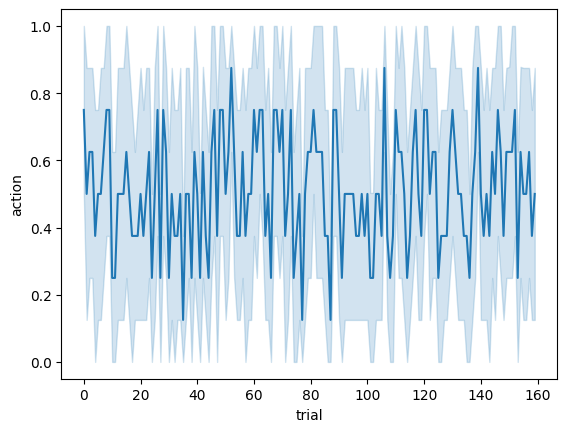

In [17]:
plt.figure()
sns.lineplot(data=plot_df, x="trial", y="action")#, hue="subject")
plt.show()

In [18]:
agent_inference_params = copy.deepcopy(pars)
agent_inference_params["forgetting_rate_pol"] = 0.
agent_inference_params["forgetting_rate_rew"] = 0.
agent_inference_params["infer_alpha_0"] = True
agent_inference_params["infer_decision_temp"] = True
agent_inference_params["infer_policy_rate"] = False
agent_inference_params["infer_reward_rate"] = False
agent_inference_params["mask"] = structured_data["valid"]
agent_inference_params["store_internal_variables"] = False

agent_inference_params["alpha_0"] = 1.
agent_inference_params["dec_temp"] = 1.

In [19]:
# prepare for saving results
# make base filename and folder string
fname_base = exp_name+"_"+agent_type+"_recovery_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(recovery_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(recovery_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 400

TMaze_BCC_1pars_planning_recovery_


In [20]:
print(structured_data)

{'subject': tensor([[0, 1, 2, 3, 4, 5, 6, 7]]), 'observations': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [2, 1, 2,  ..., 2, 2, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 1, 2, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 2, 1, 1]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 2,  ..., 2, 2, 2]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 1, 2, 2]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 2, 1, 1]]]), 'rewards': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [2, 0, 2,  ..., 2, 2, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 0, 0,  ..., 0, 2, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 2, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [2, 2, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 2, 2,  ..., 2, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 2, 2]]]), 'actions': tensor([[[ 1,  0,  1

In [21]:
run_inference = True

In [22]:
if run_inference:

    # remove old inference?
    remove_old = True

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_subjects, agent_inference_params, base_dir, remove_old=remove_old)

    print('analyzing '+str(n_subjects)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, structured_data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 50
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_subjects)+'agents'

        iu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir, true_vals=structured_true_vals) 
        param_ranges = [[0,8], [0,8]]
        iu.plot_results(sample_df, param_names, fname_str, inferrer.loss, mean_df, base_dir, param_ranges)

TypeError: expected np.ndarray (got Tensor)